# Training Cellpose 2.0 Model with Images of Varying Resolutions and Corresponding Masks


## Code Credits and Implementation Details



1.  Stringer et al. Foundational train and testing notebook structure: https://github.com/MouseLand/cellpose?tab=readme-ov-file, Cellpose Team. Cellpose Code. Available at: https://colab.research.google.com/github/MouseLand/cellpose/blob/main/notebooks/runcellpose2.ipynb.
2.  Sreenu, B. N. Python for Microscopists: Cellpose Algorithm for
Segmentation. Available at: https://github.com/bnsreenu/pythonformicroscopists/blob/master/305WhatisCellposealgorithmforsegmentation.ipynb: export_cellpose_pdf()


Remaining authors implementation:ensure_hw_c_format(), calculate_diameter(), get_diameter_for_image()

## Installation

Install cellpose -- by default the torch GPU version is installed in COLAB notebook.

In [2]:
!pip install "opencv-python-headless<4.3"
!pip install cellpose
!pip install fpdf2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 MB 17.5 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.10.0.84
    Uninstalling opencv-python-headless-4.10.0.84:
      Successfully uninstalled opencv-python-headless-4.10.0.84
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albucore 0.0.19 requires opencv-python-headless>=4.9.0.80, but you have opencv-python-headless 3.4.18.65 which is incompatible.
albumentations 1.4.20 requires opencv-python-headless>=4.9.0.80, but you have opencv-python-headless 3.4.18.65 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.2/215.2 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 117.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.4/43.4 MB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

Check CUDA version and that GPU is working in cellpose and import other libraries.

In [3]:
!nvcc --version
!nvidia-smi

import os, shutil
import numpy as np
import matplotlib.pyplot as plt
from cellpose import core, utils, io, models, metrics
from glob import glob
from skimage.measure import label
from skimage.segmentation import relabel_sequential
import numpy as np

use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
Tue Dec 31 20:02:26 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8               9W /  7

## Mount google drive


In [4]:

#@markdown ###Run this cell to connect your Google Drive to Colab

#@markdown * Click on the URL.

#@markdown * Sign in your Google Account.

#@markdown * Copy the authorization code.

#@markdown * Enter the authorization code.

#@markdown * Click on "Files" site on the right. Refresh the site. Your Google Drive folder should now be available here as "drive".

#mounts user's Google Drive to Google Colab.

from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


# Train model on manual annotations


In [5]:
#@markdown ###Path to images and masks:

train_dir = "/content/gdrive/MyDrive/CELLPOSE/dataset_11/train_model/train" #@param {type:"string"}
test_dir = "/content/gdrive/MyDrive/CELLPOSE/dataset_11/train_model/test" #@param {type:"string"}
#Define where the patch file will be saved
base = "/content"

# model name and path
#@markdown ###Name of the pretrained model to start from and new model name:
from cellpose import models
initial_model = "cyto3" #@param ["cyto", "cyto3","nuclei","tissuenet_cp3", "livecell_cp3", "yeast_PhC_cp3", "yeast_BF_cp3", "bact_phase_cp3", "bact_fluor_cp3", "deepbacs_cp3", "scratch"]
model_name = "malaria" #@param {type:"string"}

# other parameters for training.
#@markdown ###Training Parameters:
#@markdown Number of epochs:
n_epochs =  100#@param {type:"number"}

Channel_to_use_for_training = "Grayscale" #@param ["Grayscale", "Blue", "Green", "Red"]

# @markdown ###If you have a secondary channel that can be used for training, for instance nuclei, choose it here:

Second_training_channel= "None" #@param ["None", "Blue", "Green", "Red"]


#@markdown ###Advanced Parameters

Use_Default_Advanced_Parameters = True #@param {type:"boolean"}
#@markdown ###If not, please input:
learning_rate = 0.1 #@param {type:"number"}
weight_decay = 0.0001 #@param {type:"number"}

if (Use_Default_Advanced_Parameters):
  print("Default advanced parameters enabled")
  learning_rate = 0.1
  weight_decay = 0.0001

#here we check that no model with the same name already exist, if so delete
model_path = train_dir + 'models/'
if os.path.exists(model_path+'/'+model_name):
  print("!! WARNING: "+model_name+" already exists and will be deleted in the following cell !!")

if len(test_dir) == 0:
  test_dir = None

# Here we match the channel to number
if Channel_to_use_for_training == "Grayscale":
  chan = 0
elif Channel_to_use_for_training == "Blue":
  chan = 3
elif Channel_to_use_for_training == "Green":
  chan = 2
elif Channel_to_use_for_training == "Red":
  chan = 1


if Second_training_channel == "Blue":
  chan2 = 3
elif Second_training_channel == "Green":
  chan2 = 2
elif Second_training_channel == "Red":
  chan2 = 1
elif Second_training_channel == "None":
  chan2 = 0

if initial_model=='scratch':
  initial_model = 'None'

Default advanced parameters enabled


## PDF Export function for Cellpose 2.0 Model Pretrained

In [14]:
from fpdf import FPDF, HTMLMixin
from datetime import datetime
import os

'Sreenu, B. N. Python for Microscopists: Cellpose Algorithm for Segmentation. Available at: https://github.com/bnsreenu/pythonformicroscopists/blob/master/305WhatisCellposealgorithmforsegmentation.ipynb'
# PDF Export function for Cellpose 2.0 Model Pretrained

def export_cellpose_pdf(train_masks, test_masks, train_dir, test_dir, new_model_path, train_losses, test_losses, n_epochs, learning_rate, weight_decay, model_name, diam_labels):
    class MyFPDF(FPDF, HTMLMixin):
        pass

    pdf = MyFPDF()
    pdf.add_page()
    pdf.set_font("Arial", size=11, style='B')

    # Header Section
    day = datetime.now()
    datetime_str = day.strftime('%Y-%m-%d')
    header = f"Training Report for Cellpose 2.0 Model\nModel: {model_name}\nDate: {datetime_str}"
    pdf.multi_cell(180, 10, txt=header, align='L')

    # Model Information Section
    pdf.set_font("Arial", size=10)
    pdf.ln(5)
    pdf.cell(0, 10, txt="Training Summary:", ln=1, align='L')
    pdf.cell(0, 10, txt=f"Pretrained Model: {model_name}", ln=1)
    pdf.cell(0, 10, txt=f"Epochs: {n_epochs}", ln=1)
    pdf.cell(0, 10, txt=f"Learning Rate: {learning_rate}", ln=1)
    pdf.cell(0, 10, txt=f"Weight Decay: {weight_decay}", ln=1)
    pdf.cell(0, 10, txt=f"Diameter of Labels: {diam_labels:.2f}", ln=1)

    # Data Information Section
    pdf.ln(5)
    pdf.cell(0, 10, txt="Dataset Information:", ln=1, align='L')
    pdf.cell(0, 10, txt=f"Number of Training Masks: {len(train_masks)}", ln=1)
    pdf.cell(0, 10, txt=f"Number of Testing Masks: {len(test_masks)}", ln=1)

    pdf.cell(0, 10, txt=f"Training Directory: {train_dir}", ln=1)
    pdf.cell(0, 10, txt=f"Testing Directory: {test_dir}", ln=1)

    # Training and Testing Loss
    pdf.ln(5)
    pdf.cell(0, 10, txt="Loss Summary:", ln=1, align='L')
    pdf.cell(0, 10, txt=f"Final Training Loss: {train_losses[-1]:.4f}", ln=1)
    pdf.cell(0, 10, txt=f"Final Testing Loss: {test_losses[-1]:.4f}", ln=1)

    # Model Output
    pdf.ln(5)
    pdf.cell(0, 10, txt="Model Output:", ln=1, align='L')
    pdf.cell(0, 10, txt=f"Model Path: {new_model_path}", ln=1)

    # Reminder and References
    pdf.ln(5)
    pdf.set_font("Arial", size=11, style='B')
    reminder = (
        "Important:\n"
        "- Ensure to perform quality control on the trained model.\n"
        "- Consider sharing your dataset or model on platforms like Zenodo."
    )
    pdf.multi_cell(180, 8, txt=reminder, align='L')

    pdf.ln(5)
    pdf.set_font("Arial", size=10)
    references = (
        "References:\n"
        "1. Cellpose 2.0: Stringer et al., Nature Methods (2021).\n"
        "2. ZeroCostDL4Mic: von Chamier et al., BioRxiv (2020)."
    )
    pdf.multi_cell(180, 8, txt=references, align='L')

    # Save PDF
    pdf_output_path = os.path.join(new_model_path.parents[0], f"{model_name}_training_report.pdf")
    pdf.output(pdf_output_path)
    print(f"PDF Report saved to {pdf_output_path}")

# Example function usage:
# Ensure you pass the appropriate variables for the following call.
# export_cellpose_pdf(train_masks, test_masks, train_dir, test_dir, new_model_path, train_losses, test_losses, n_epochs, learning_rate, weight_decay, model_name, diam_labels)


## Train new model


In [6]:
train_masks = [f for f in os.listdir(train_dir) if f.endswith('_masks.png')]
test_masks = [f for f in os.listdir(test_dir) if f.endswith('_masks.png')]

In [7]:
def ensure_hw_c_format(data):
    """Ensures that all images are in the H, W, C format."""
    converted_data = []
    for img in data:
        shape = img.shape
        if len(shape) == 3:
            if shape[0] == 3:  # C, H, W -> H, W, C
                img = np.transpose(img, (1, 2, 0))
            elif shape[-1] != 3:  # Unexpected format
                raise ValueError(f"Unexpected image shape: {shape}. Expected H, W, C or C, H, W.")
        elif len(shape) == 2:  # Grayscale image, add channel dimension
            img = np.expand_dims(img, axis=-1)
        converted_data.append(img)
    return converted_data

In [8]:
from cellpose import train

# start logger (to see training across epochs)
logger = io.logger_setup()

# DEFINE CELLPOSE MODEL (without size model)
model = models.CellposeModel(gpu=use_GPU, model_type=initial_model)

# set channels
channels = [chan, chan2]

# get files
output = io.load_train_test_data(train_dir, test_dir, mask_filter="_masks")#_seg.npy')
train_data, train_labels, _, test_data, test_labels, test_files = output

# ensures that all images are in the H, W, C format
train_data = ensure_hw_c_format(train_data)
test_data = ensure_hw_c_format(test_data)

new_model_path, train_losses, test_losses = train.train_seg(model.net, train_data=train_data,
                              train_labels=train_labels,
                              test_data=test_data,
                              test_labels=test_labels,
                              channels=channels,
                              save_path=train_dir,
                              n_epochs=n_epochs,
                              learning_rate=learning_rate,
                              weight_decay=weight_decay,
                              SGD=True,
                              nimg_per_epoch=8,
                              model_name=model_name)

# diameter of labels in training images
diam_labels = model.net.diam_labels.item()

creating new log file


100%|██████████| 25.3M/25.3M [00:03<00:00, 8.82MB/s]
/usr/local/lib/python3.10/dist-packages/cellpose/resnet_torch.py:271: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  stat

In [9]:
print(f"train_data shape: {[d.shape for d in train_data]}")
print(f"train_labels shape: {[l.shape for l in train_labels]}")
print(f"test_data shape: {[d.shape for d in test_data]}")
print(f"test_labels shape: {[l.shape for l in test_labels]}")


train_data shape: [(1200, 1600, 3), (120, 160, 3), (240, 320, 3), (360, 480, 3), (480, 640, 3), (600, 800, 3), (720, 960, 3), (840, 1120, 3), (960, 1280, 3), (1080, 1440, 3), (1200, 1600, 3), (120, 160, 3), (240, 320, 3), (360, 480, 3), (480, 640, 3), (600, 800, 3), (720, 960, 3), (840, 1120, 3), (960, 1280, 3), (1080, 1440, 3), (1200, 1600, 3), (120, 160, 3), (240, 320, 3), (360, 480, 3), (480, 640, 3), (600, 800, 3), (720, 960, 3), (840, 1120, 3), (960, 1280, 3), (1080, 1440, 3), (1200, 1600, 3), (120, 160, 3), (240, 320, 3), (360, 480, 3), (480, 640, 3), (600, 800, 3), (720, 960, 3), (840, 1120, 3), (960, 1280, 3), (1080, 1440, 3), (1200, 1600, 3), (120, 160, 3), (240, 320, 3), (360, 480, 3), (480, 640, 3), (600, 800, 3), (720, 960, 3), (840, 1120, 3), (960, 1280, 3), (1080, 1440, 3), (1200, 1600, 3), (120, 160, 3), (240, 320, 3), (360, 480, 3), (480, 640, 3), (600, 800, 3), (720, 960, 3), (840, 1120, 3), (960, 1280, 3), (1080, 1440, 3)]
train_labels shape: [(1200, 1600), (120, 160)

In [10]:
new_model_path

PosixPath('/content/gdrive/MyDrive/CELLPOSE/dataset_11/train_model/train/models/malaria')

In [11]:
diam_labels

24.320735931396484

In [15]:
export_cellpose_pdf(train_masks, test_masks, train_dir, test_dir, new_model_path, train_losses, test_losses, n_epochs, learning_rate, weight_decay, model_name, diam_labels)

PDF Report saved to /content/gdrive/MyDrive/CELLPOSE/dataset_11/train_model/train/models/malaria_training_report.pdf


<ipython-input-14-0c00b24d7f8e>:12: DeprecationWarning: The HTMLMixin class is deprecated since v2.6.0. Simply use the FPDF class as a replacement.
  pdf = MyFPDF()
<ipython-input-14-0c00b24d7f8e>:14: DeprecationWarning: Substituting font arial by core font helvetica - This is deprecated since v2.7.8, and will soon be removed
  pdf.set_font("Arial", size=11, style='B')
<ipython-input-14-0c00b24d7f8e>:20: DeprecationWarning: The parameter "txt" has been renamed to "text" in 2.7.6
  pdf.multi_cell(180, 10, txt=header, align='L')
<ipython-input-14-0c00b24d7f8e>:23: DeprecationWarning: Substituting font arial by core font helvetica - This is deprecated since v2.7.8, and will soon be removed
  pdf.set_font("Arial", size=10)
<ipython-input-14-0c00b24d7f8e>:25: DeprecationWarning: The parameter "txt" has been renamed to "text" in 2.7.6
  pdf.cell(0, 10, txt="Training Summary:", ln=1, align='L')
<ipython-input-14-0c00b24d7f8e>:25: DeprecationWarning: The parameter "ln" is deprecated since v2.5

## Evaluate on test data (optional)


In [16]:
import math

# Predefined mapping of dimensions to diameters
dimension_to_diameter = {
    "1200x1600": 45,
    "120x160": 4.5,
    "240x320": 9.0,
    "360x480": 13.5,
    "480x640": 18.0,
    "600x800": 22.5,
    "720x960": 27.0,
    "840x1120": 31.5,
    "960x1280": 36.0
}

# Function to calculate the diameter for unknown dimensions
def calculate_diameter(height, width):
    # Use a proportional constant based on a known reference dimension
    reference_key = "1200x1600"
    reference_diameter = dimension_to_diameter[reference_key]
    reference_height, reference_width = map(int, reference_key.split('x'))

    # Calculate the diagonal of the reference dimension and the given dimension
    reference_diagonal = math.sqrt(reference_height**2 + reference_width**2)
    given_diagonal = math.sqrt(height**2 + width**2)

    # Scale the diameter proportionally
    return (given_diagonal / reference_diagonal) * reference_diameter

# Function to determine the diameter based on image dimensions
def get_diameter_for_image(image, dimension_to_diameter):
    height, width = image.shape[:2]
    dimension_key = f"{height}x{width}"
    if dimension_key in dimension_to_diameter:
        return dimension_to_diameter[dimension_key]
    else:
        # Calculate the diameter for unknown dimensions
        return calculate_diameter(height, width)


In [17]:
# get files (during training, test_data is transformed so we will load it again)
output = io.load_train_test_data(test_dir, mask_filter="_masks")#_seg.npy')
test_data, test_labels = output[:2]
test_data = ensure_hw_c_format(test_data)
# Calculation diameter for test data
test_diameters = [get_diameter_for_image(img, dimension_to_diameter) for img in test_data]

# Collect results
masks_list = []
for img, diameter in zip(test_data, test_diameters):
    # Evaluate the model for each image with its individual diameter
    masks = model.eval([img],
                       channels=[chan, chan2],
                       diameter=diameter)[0]
    masks_list.append(masks)

# Flatten the mask list to ensure it's a single-level list
flattened_masks = [mask[0] if isinstance(mask, list) else mask for mask in masks_list]

# Calculate the average precision
ap = metrics.average_precision(test_labels, flattened_masks)[0]
print('')
print(f'>>> average precision at iou threshold 0.5 = {ap[:,0].mean():.3f}')



>>> average precision at iou threshold 0.5 = 0.867


In [18]:
print(*test_diameters)

45 4.5 9.0 13.5 18.0 22.5 27.0 31.5 36.0 40.5 45 4.5 9.0 13.5 18.0 22.5 27.0 31.5 36.0 40.5 45 4.5 9.0 13.5 18.0 22.5 27.0 31.5 36.0 40.5 45 4.5 9.0 13.5 18.0 22.5 27.0 31.5 36.0 40.5 45 4.5 9.0 13.5 18.0 22.5 27.0 31.5 36.0 40.5 45 4.5 9.0 13.5 18.0 22.5 27.0 31.5 36.0 40.5


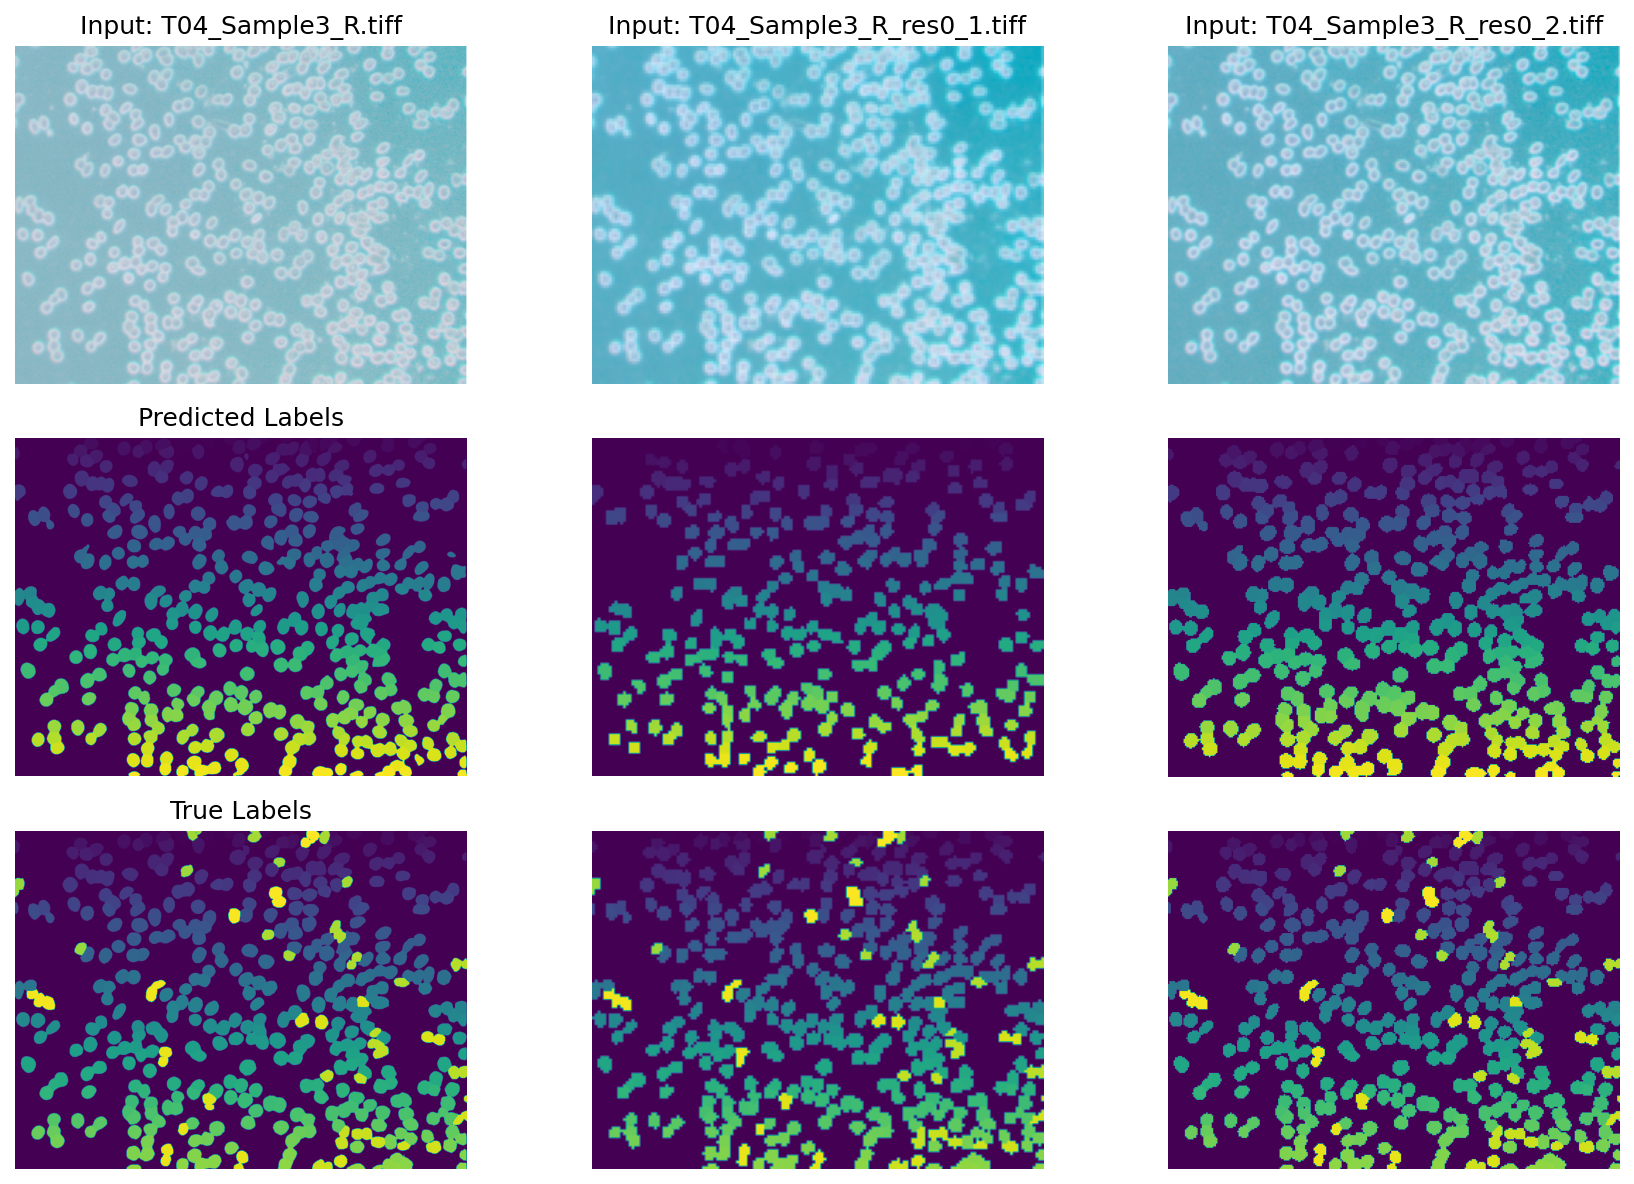

In [19]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 8), dpi=150)

# Number of test images
n_images = min(3, len(test_data))

for k, (im, file) in enumerate(zip(test_data[:n_images], test_files[:n_images])):
    # Copy the image
    img = im.copy()

    # Transform if channels are in the first dimension
    if img.shape[0] == 3 and img.ndim == 3:
        img = img.transpose(1, 2, 0)  # Convert to (height, width, channels)

    # Normalize image data
    if img.dtype != np.uint8:
        img = (img - img.min()) / (img.max() - img.min())  # Normalize to 0–1
        img = (img * 255).astype(np.uint8)  # Scale to 0–255

    # Display input image
    plt.subplot(3, n_images, k + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Input: {os.path.basename(file)}')

    # Display predicted labels
    plt.subplot(3, n_images, n_images + k + 1)
    plt.imshow(flattened_masks[k], cmap='viridis')  # Use an appropriate colormap
    plt.axis('off')
    if k == 0:
        plt.title('Predicted Labels')

    # Display true labels
    plt.subplot(3, n_images, 2 * n_images + k + 1)
    plt.imshow(test_labels[k], cmap='viridis')  # Use the same colormap as for masks
    plt.axis('off')
    if k == 0:
        plt.title('True Labels')

plt.tight_layout()
plt.show()